# Overview:
**Project Objective:** Create a classifier to predict Named Entities from words

**Problem Type:** This is a supervised learning classification problem

**Performance Measures:**
- Accuracy: Correct Predictions / Total Predictions
- Precision: True Positives / Total Positives
- Recall: True Positives / Actual Positives
- F1-Score: Weighted average of Precision and Recall

Mostly importantly, our goal is to accurately identify Named Entities. Therefore, the focus should be on the Recall and F1-Score of our various entity classes, with less emphasis on non-entity words. That being said, we still need to be mindful of our False Positives. The **Macro F1-Score** may be our most appropriate metric since our classes are significantly imbalanced, which calculates the average, unweighted, F1-Score from each class label.

**Imports:**

In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

from keras import layers, models
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer

import unicodedata
import sys

# Import Data
We apparently have a non-ascii character in the data which  can't be encoded/decoded during normal parsing. Therefore, we will read the data in as one string per row and parse manually.

In [2]:
data_import = pd.read_csv("Dataset_01-29-2019.txt",sep="  ")

C:\Users\RHedg\.conda\envs\opencv\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [6]:
data_import.head()

,Sentence # Word POS Tag
0,0\t1.0\tThousands\tNNS\tO
1,1\t1.0\tof\tIN\tO
2,2\t1.0\tdemonstrators\tNNS\tO
3,3\t1.0\thave\tVBP\tO
4,4\t1.0\tmarched\tVBN\tO


In [4]:
data_import.shape

(66161, 1)

Fix our dataframe by extracting original columns:

In [13]:
columns = ['Sentence #','Word','POS','Tag']
fix_df = pd.DataFrame(columns = columns)
for i in np.arange(data_import.shape[0]):
    row = pd.Series(np.array(data_import.iloc[i].values[0].split())[1:],
         index=columns)
    fix_df = fix_df.append(row, ignore_index=True)
    if i % 10000 == 0:
        print(i)

0
10000
20000
30000
40000
50000
60000


# Data Preparation (Cleaning, Exploration, and Feature Engineering)

Start by examining high-level data characteristics:

In [18]:
fix_df.head()

,Sentence #,Word,POS,Tag
0,1.0,Thousands,NNS,O
1,1.0,of,IN,O
2,1.0,demonstrators,NNS,O
3,1.0,have,VBP,O
4,1.0,marched,VBN,O


In [60]:
df = fix_df.copy()
df.shape

(66161, 4)

In [61]:
df.head(10)

,Sentence #,Word,POS,Tag
0,1.0,Thousands,NNS,O
1,1.0,of,IN,O
2,1.0,demonstrators,NNS,O
3,1.0,have,VBP,O
4,1.0,marched,VBN,O
5,1.0,through,IN,O
6,1.0,London,NNP,B-geo
7,1.0,to,TO,O
8,1.0,protest,VB,O
9,1.0,the,DT,O


In [62]:
df.describe()

,Sentence #,Word,POS,Tag
count,66161,66161,66161,66161
unique,2999,8766,41,17
top,2549.0,the,NN,O
freq,70,3292,9307,56217


In [63]:
df.dtypes

Sentence #    object
Word          object
POS           object
Tag           object
dtype: object

### Some initial thoughts:
- Our raw data contains four variables, including our target: Sentence # (str), Word (str), POS (str), and Tag (str)
- While **Sentence #** won't be directly helpful in our models, it will be used to help disect sentences and assist with feature extraction
- The **Word** variable will be the root of all of our other features. A few initial ideas of transformations/feature extractions that can be applied are:
    - Word vectorization
    - Prior word(s) vectorization
    - Next word(s) vectorization
    - Length of word
    - POS of word/prior word/next word vectorization
    - Stemming of word
    - Capitalization of word indicator
    - Index of word within sentence (first word indicator, last word indicator, index, etc.)
    - Stop word / common word indicator
    - Punctuation
    - Number vs. String

Let's check for any **missing values** in our dataset. Return all columns containing missing values sorted by frequency:
- Our output indicates that there are no missing values in our dataset

In [64]:
Missing_count = pd.DataFrame(df.isna().sum().sort_values(ascending=False),
                             columns=['Count'])
Missing_count[Missing_count['Count'] != 0]

,Count


Let's take a quick look at our **Tag variable** and the relative frequencies:

In [65]:
df.groupby('Tag').count().iloc[:,0]

Tag
B-art       53
B-eve       45
B-geo     2070
B-gpe     1230
B-nat       20
B-org     1237
B-per     1107
B-tim     1160
I-art       34
I-eve       37
I-geo      414
I-gpe       34
I-nat        9
I-org      926
I-per     1234
I-tim      334
O        56217
Name: Sentence #, dtype: int64

For this analysis, we will ignore the 'Beginning' (B) and 'Inside' (I) indicators and focus on the specific entity classes: geo, org, per, gpe, tim, art, eve, and nat. Therefore, I will remove the prefixes of 'I' and 'B' from our Tag variable.

In [66]:
def cut_y(x):
    if x != "O":
        return x[2:]
    else:
        return x

df['Tag'] = df['Tag'].apply(lambda x: cut_y(x))

Let's create a few visualizations to better understand our initial variables:

Text(0, 0.5, 'Count')

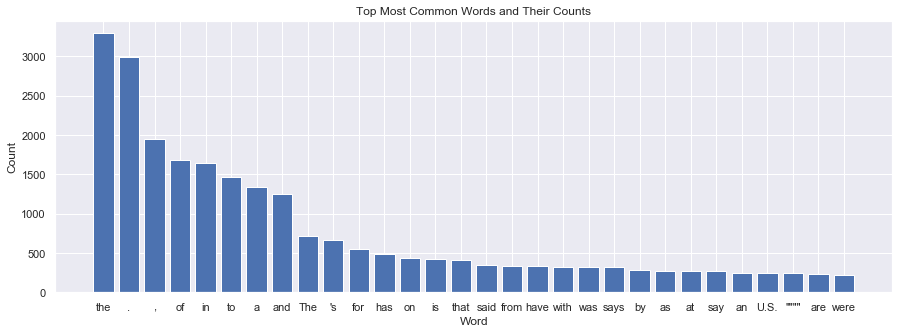

In [67]:
# Word Frequency
top_words = pd.DataFrame(df.groupby('Word')['Sentence #'].\
                            count().sort_values(ascending=False))[:30]
plt.figure(figsize=(15,5))
plt.bar(top_words.index,top_words['Sentence #'])
plt.title("Top Most Common Words and Their Counts")
plt.xlabel("Word")
plt.ylabel("Count")

Our most common words are dominated by very common words, many of which are stop words. There are also punctuation symbols present.

Text(0, 0.5, 'Count')

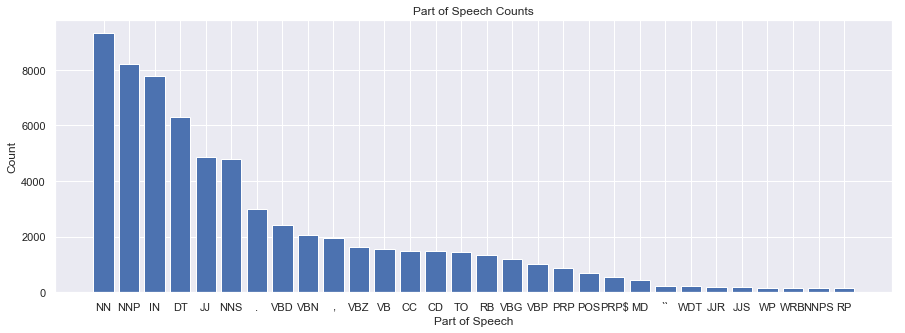

In [68]:
# POS Frequency
top_POS = pd.DataFrame(df.groupby('POS')['Sentence #'].\
                            count().sort_values(ascending=False))[:30]
plt.figure(figsize=(15,5))
plt.bar(top_POS.index,top_POS['Sentence #'])
plt.title("Part of Speech Counts")
plt.xlabel("Part of Speech")
plt.ylabel("Count")

Our most common POS's are singular noun, proper noun, preposition, determiner, adjective, and plural noun, in that order. There are roughly 30 different POS's, but 10 of them make up the majority.

Text(0, 0.5, 'Count')

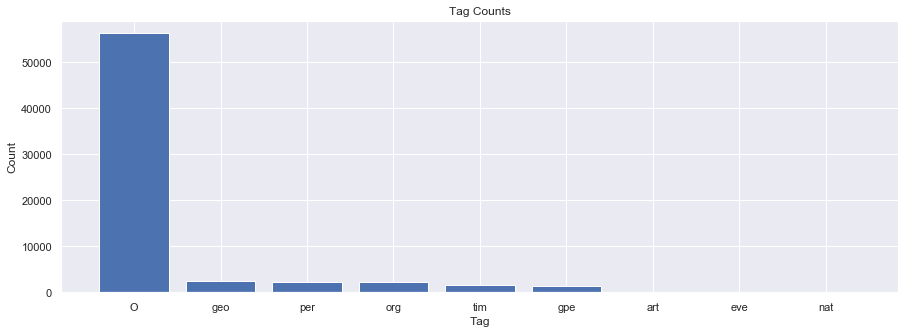

In [69]:
# Tag Frequency
tag_counts = pd.DataFrame(df.groupby('Tag')['Sentence #'].\
                            count().sort_values(ascending=False))
plt.figure(figsize=(15,5))
plt.bar(tag_counts.index,tag_counts['Sentence #'])
plt.title("Tag Counts")
plt.xlabel("Tag")
plt.ylabel("Count")

The 'O' tag represents roughly 85% of all words. This creates massive label imbalance, which we will need to keep our eye on during modeling. Let's examine the same distribution without the 'O' label:

Text(0, 0.5, 'Count')

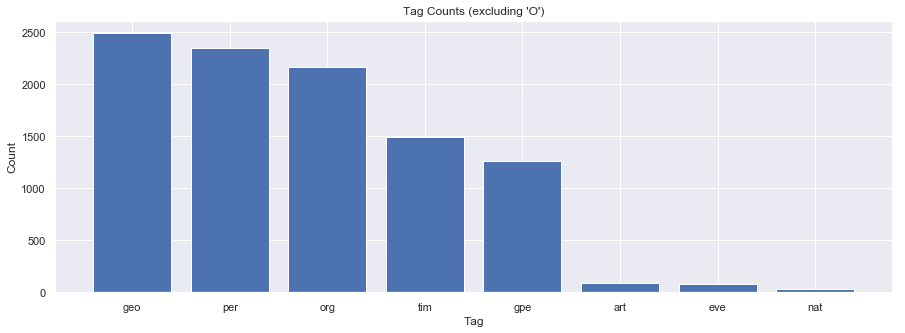

In [70]:
# Tag Frequency excluding 'O'
tag_counts = pd.DataFrame(df.groupby('Tag')['Sentence #'].\
                            count().sort_values(ascending=False))[1:]
plt.figure(figsize=(15,5))
plt.bar(tag_counts.index,tag_counts['Sentence #'])
plt.title("Tag Counts (excluding 'O')")
plt.xlabel("Tag")
plt.ylabel("Count")

The most common entities are Geographical Entity, Person, and Organization, followed by Time Indicator, and Geopolitical Entity. Artifact, Event, and Natural Phenomenon have very few instances. Even when excluding 'O', there is still significant class imbalance.

### Feature Engineering
- During the following section, we will generate additional features to be used during modeling.

- Note that during the modeling phase, the 2nd 'previous', and the 2nd 'next' word vectorizations did not improve the model, but added approximately 16K additional dimensions and thus added significant computational complexity, so these were discarded from the models.

In [71]:
df.head()

,Sentence #,Word,POS,Tag
0,1.0,Thousands,NNS,O
1,1.0,of,IN,O
2,1.0,demonstrators,NNS,O
3,1.0,have,VBP,O
4,1.0,marched,VBN,O


In [72]:
# create a copy of our original raw word, which we will use for our baseline model
df['Word_raw'] = df['Word'].copy()



# start by removing all punctuation from words, which should make the steps that follow cleaner
# create a dictionary of punctuation characters
punctuation = dict.fromkeys(i for i in range(sys.maxunicode)
                            if unicodedata.category(chr(i)).startswith('P'))
# strip punctuation characters from each word
df['Word'] = df['Word'].apply(lambda x: x.translate(punctuation))
# df['Word'] = [i.translate(punctuation) for i in df['Word']]

# extract the stem of the word
porter = PorterStemmer()
df['Word_stem'] = df['Word'].apply(lambda x: porter.stem(x))
# df['Word_stem'] = [porter.stem(x) for x in df['Word']]



# create shifted variables to represent prior two words and their respective POS,
    # and next 2 words and their POS
def create_shifted_vars(df, x):
    # create temp vars of shifted (lagged/future) var
    df['shift_sent'] = df['Sentence #'].shift(x) 
    df['shift_word'] = df['Word_stem'].shift(x)
    df['shift_pos'] = df['POS'].shift(x)
    def prev_word(i):
        if df['Sentence #'][i] == df['shift_sent'][i]: # check if word is of same sentence as lagged var
            return [df['shift_word'][i], df['shift_pos'][i]] # if so, return lagged/future var
        else:
            return ['NA','NA']
    if x > 0: # specify whether lagged/future var is a previous var or future var for var naming purposes to follow
        position = 'prev'
    else:
        position = 'next'
    # now define and generate our lagged and future vars
    df[position+str(x)+'_word'] = [prev_word(i)[0] for i in np.arange(df.shape[0])]
    df[position+str(x)+'_pos'] = [prev_word(i)[1] for i in np.arange(df.shape[0])]
    df = df.drop(['shift_sent','shift_word','shift_pos'], axis=1)
    return df
for i in [2,1,-1, -2]: # represents words for 2 prior, 1 prior, 1 future, and 2 future, respectively
    df = create_shifted_vars(df,i)



# create var to represent length of word
df['word_len'] = df['Word'].apply(lambda x: len(x))
df['word_len'] = df['word_len'] / np.max(df['word_len']) # normalize



# create binary var to capture words that are digits
df['digit_ind'] = df['Word'].apply(lambda x: np.sum(x.isdigit()))
# df['digit_ind'] = [np.sum(i.isdigit()) for i in df['Word']]



# create binary var to capture word beginning with upper case
df['word_upper'] = df['Word'].apply(lambda x: np.sum(x.istitle()))
# df['word_upper'] = [np.sum(i.istitle()) for i in df['Word']]



# create binary var to capture where word is the first word of a sentence
def first_word_ind(df):
    df['shift_sent'] = df['Sentence #'].shift(1) # create temp var of 'Sentence #' shifted downwards
    def check(i):
        if df['Sentence #'][i] != df['shift_sent'][i]: # check if word sentence is same a shifted var
            return 1 # if it's not, then it's the first word of sentence
        else:
            return 0
    df['First_word'] = [check(i) for i in np.arange(df.shape[0])]
    df = df.drop('shift_sent', axis=1)
    return df
df = first_word_ind(df)



# create binary var to capture where word is the last word of a sentence
def last_word_ind(df):
    df['shift_sent'] = df['Sentence #'].shift(-1) # create temp var of 'Sentence #' shifted upwards
    def check(i):
        if df['Sentence #'][i] != df['shift_sent'][i]: # check if word sentence is same a shifted var
            return 1 # if it's not, then it's the last word of sentence
        else:
            return 0
    df['Last_word'] = [check(i) for i in np.arange(df.shape[0])]
    df = df.drop('shift_sent', axis=1)
    return df
df = last_word_ind(df)



# create an indicator te represent very common words
stop_words = stopwords.words('english')
def is_stop_word(x):
    if x in stop_words:
        return 1
    else:
        return 0
df['stop_word'] = df['Word'].apply(lambda x: is_stop_word(x))

In [73]:
df.head()

,Sentence #,Word,POS,Tag,Word_raw,Word_stem,prev2_word,prev2_pos,prev1_word,prev1_pos,next-1_word,next-1_pos,next-2_word,next-2_pos,word_len,digit_ind,word_upper,First_word,Last_word,stop_word
0,1.0,Thousands,NNS,O,Thousands,thousand,NA,NA,NA,NA,of,IN,demonstr,NNS,0.36,0,1,1,0,0
1,1.0,of,IN,O,of,of,NA,NA,thousand,NNS,demonstr,NNS,have,VBP,0.08,0,0,0,0,1
2,1.0,demonstrators,NNS,O,demonstrators,demonstr,thousand,NNS,of,IN,have,VBP,march,VBN,0.52,0,0,0,0,0
3,1.0,have,VBP,O,have,have,of,IN,demonstr,NNS,march,VBN,through,IN,0.16,0,0,0,0,1
4,1.0,marched,VBN,O,marched,march,demonstr,NNS,have,VBP,through,IN,london,NNP,0.28,0,0,0,0,0


Lastly, for all of our **prior word**, **current word**, and **next word** features, in addition to their respective **POS** features, we will vectorize our data and bring them together to finalize our dataset.

In [77]:
# Vectorize Words
count = CountVectorizer(stop_words=stop_words, max_features=1000)
bag_of_words = count.fit_transform(df['Word_raw']).toarray()

# Vectorize Word_stem
count01 = CountVectorizer(stop_words=stop_words, max_features=1000)
word_vec = count01.fit_transform(df['Word_stem']).toarray()

# Vectorize POS
count02 = CountVectorizer()
pos_vec = count02.fit_transform(df['POS']).toarray()

# Vectorize prev1_word
count03 = CountVectorizer(max_features=150)
prev1_word_vec = count03.fit_transform(df['prev1_word']).toarray()

# Vectorize prev1_pos
count04 = CountVectorizer()
prev1_pos_vec = count04.fit_transform(df['prev1_pos']).toarray()

# Vectorize prev2_word
count05 = CountVectorizer(max_features=150)
prev2_word_vec = count05.fit_transform(df['prev2_word']).toarray()

# Vectorize prev2_pos
count06 = CountVectorizer()
prev2_pos_vec = count06.fit_transform(df['prev2_pos']).toarray()

# Vectorize next1_word
count07 = CountVectorizer(max_features=150)
next1_word_vec = count07.fit_transform(df['next-1_word']).toarray()

# Vectorize next1_pos
count08 = CountVectorizer()
next1_pos_vec = count08.fit_transform(df['next-1_pos']).toarray()

# Vectorize next2_word
count09 = CountVectorizer(max_features=150)
next2_word_vec = count09.fit_transform(df['next-2_word']).toarray()

# Vectorize next2_pos
count10 = CountVectorizer()
next2_pos_vec = count10.fit_transform(df['next-2_pos']).toarray()

At this stage, we will designate a final test set to pull out and put aside until the very end, as well as create training and validation sets.

In [126]:
np.random.seed(1)
group_indices = np.arange(1,np.max(df['Sentence #'].apply(lambda x: float(x)))) # create index vector
np.random.shuffle(group_indices) # shuffle index vector

# create index vectors to represent test, validation, and train groups
test_indices, validation_indices, train_indices = np.split(group_indices,
                                                  [int(len(group_indices)*.1),
                                                   int(len(group_indices)*.3)])

Our train, validation, and test indices will then get applied to the various feature combinations that will be used in the modeling section:

In [127]:
def translate_group(x):
    if float(x) in test_indices:
        return 'test'
    elif float(x) in validation_indices:
        return 'validation'
    else:
        return 'train'

df['Model_group'] = df['Sentence #'].apply(lambda x: translate_group(x))

In [141]:
# Originally provided data (for baseline model)
original_X = np.hstack((bag_of_words,
                        pos_vec,
                       df['Model_group'][:,np.newaxis]))
orig_X_test = original_X[original_X[:,-1] == 'test'][:,:-1]
orig_X_validation = original_X[original_X[:,-1] == 'validation'][:,:-1]
orig_X_train = original_X[original_X[:,-1] == 'train'][:,:-1]


# All data
all_X = np.hstack((word_vec,
                   pos_vec,
                   prev1_word_vec,
                   prev1_pos_vec,
#                    prev2_word_vec,
                   prev2_pos_vec,
                   next1_word_vec,
                   next1_pos_vec,
#                    next2_word_vec,
                   next2_pos_vec,
                   df['word_len'][:,np.newaxis],
                   df['word_upper'][:,np.newaxis],
                   df['digit_ind'][:,np.newaxis],
                   df['First_word'][:,np.newaxis],
                   df['stop_word'][:,np.newaxis],
                   df['Model_group'][:,np.newaxis]))
all_X_test = all_X[all_X[:,-1] == 'test'][:,:-1]
all_X_validation = all_X[all_X[:,-1] == 'validation'][:,:-1]
all_X_train = all_X[all_X[:,-1] == 'train'][:,:-1]


# no word vecs, POS and indicator vars only (significanly fewer dimensions)
pos_X = np.hstack((pos_vec,
                   prev1_pos_vec,
                   prev2_pos_vec,
                   next1_pos_vec,
                   next2_pos_vec,
                   df['word_len'][:,np.newaxis],
                   df['word_upper'][:,np.newaxis],
                   df['digit_ind'][:,np.newaxis],
                   df['First_word'][:,np.newaxis],
                   df['stop_word'][:,np.newaxis],
                   df['Model_group'][:,np.newaxis]))
pos_X_test = pos_X[pos_X[:,-1] == 'test'][:,:-1]
pos_X_validation = pos_X[pos_X[:,-1] == 'validation'][:,:-1]
pos_X_train = pos_X[pos_X[:,-1] == 'train'][:,:-1]


# target feature
y_test = df['Tag'][df['Model_group'] == 'test'].values
y_validation = df['Tag'][df['Model_group'] == 'validation'].values
y_train = df['Tag'][df['Model_group'] == 'train'].values

In [142]:
print("Number of features for baseline model: ", original_X.shape[1])
print("Number of features for using all data: ", all_X.shape[1])
print("Number of features excluding word vectorizations: ", pos_X.shape[1])

Number of features for baseline model:  1034
Number of features for using all data:  1474
Number of features excluding word vectorizations:  174


# Modeling

### Baseline Model:
- We will start with an **SVM** approach, as SVMs are often appropriate for text-based classification and they scale nicely to very high dimensions.

**1) Linear SVC with only 'Word' and 'POS' Vectorizations**
- To set a baseline performance, we will use a Linear SVM model with default parameters using only the original Vectorized words and their part of speech as our features. This way, we can also isolate and measure our model improvement through the impact of the feature enginnering steps.

**Results:**
- Overall Accuracy = 0.941
- Macro F1-score: 0.515

The strength of our overall accuracy and f1-score is driven up by the 'O' class, while our Named Entity performance is significantly weaker. Since our priority is identifying Named Entities, the macro F1-score (unweighted average of all F1-Scores) will be our metric of focus.

In [138]:
svm = LinearSVC()
svm.fit(orig_X_train,y_train)
preds = svm.predict(orig_X_validation)
baseline_acc = accuracy_score(y_validation, preds)
baseline_f1 = f1_score(y_validation, preds, average='macro')
print("Overall Accuracy: ", baseline_acc)
print("Macro F1-Score: ", baseline_f1)

Overall Accuracy:  0.9407765523492975
Macro F1-Score:  0.5152333614670116


C:\Users\RHedg\.conda\envs\opencv\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [139]:
print(classification_report(y_validation, preds))

              precision    recall  f1-score   support

           O       0.98      1.00      0.99     11290
         art       0.00      0.00      0.00        13
         eve       0.83      0.22      0.34        23
         geo       0.77      0.57      0.66       500
         gpe       0.91      0.55      0.68       267
         nat       0.00      0.00      0.00         8
         org       0.77      0.44      0.56       395
         per       0.51      0.96      0.67       460
         tim       0.96      0.60      0.74       282

   micro avg       0.94      0.94      0.94     13238
   macro avg       0.64      0.48      0.52     13238
weighted avg       0.95      0.94      0.94     13238



C:\Users\RHedg\.conda\envs\opencv\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\RHedg\.conda\envs\opencv\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\RHedg\.conda\envs\opencv\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Improved Models:
**2) Linear SVC with Additional Generated Features**
- Here, we will still use the default parameters of a Linear SVC, however now we will include our newly engineered features. This will allow us to isolate the impact of simply creating and adding the new features.

**Results:**
- Overall Accuracy = 0.960 (improvement of 1.9 % points over baseline)
- Macro F1-score: 0.598 (improvement of 8.3 % points over baseline)

In [143]:
svm = LinearSVC()
svm.fit(all_X_train,y_train)
preds = svm.predict(all_X_validation)
add_features_acc = accuracy_score(y_validation, preds)
add_features_f1 = f1_score(y_validation, preds, average='macro')
print("Overall Accuracy: ", add_features_acc)
print("Macro F1-Score: ", add_features_f1)

Overall Accuracy:  0.9599637407463363
Macro F1-Score:  0.5980913866671917


In [144]:
print(classification_report(y_validation,preds))

              precision    recall  f1-score   support

           O       0.99      0.99      0.99     11290
         art       0.00      0.00      0.00        13
         eve       0.69      0.39      0.50        23
         geo       0.74      0.83      0.78       500
         gpe       0.84      0.69      0.76       267
         nat       0.00      0.00      0.00         8
         org       0.77      0.63      0.69       395
         per       0.81      0.90      0.85       460
         tim       0.89      0.73      0.80       282

   micro avg       0.96      0.96      0.96     13238
   macro avg       0.64      0.57      0.60     13238
weighted avg       0.96      0.96      0.96     13238



**3) SVC with tuned missclassification penalty parameter**
- A variety of SVM variations were explored, including the use of RBF kernel transformations (with and without PCA Dimension Reduction beforehand) and class-specific class-weighted C error parameters to vary the penalty for missclassification depending on class size (penalize missclassification of smaller class sizes more heavily). However, with the added computational complexity combined with limited to no added predictive value, it was decided to simply tune a single universal missclassification penalty parameter for the final SVM.

**Results:**
- Overall Accuracy = 0.960 (improvement of 1.6 % points over baseline)
- Macro F1-score: 0.600 (improvement of 8.5 % points over baseline)


Note that a few of our smaller Named Entities remain difficult to classify with high recall (Artifact, Event, Natural Phenomenon). Using our Confusion Matrix, we can see that many of the instances where we predicted a word to be outside of a named entity, it was in fact an Organization, Time Indicator, or Geographical Entity. Additionally, for many words that were predicted to be a Geographical Entity, they were in fact a Geopolitical Entity or an Organization.

Below we will tune our error penalty parameter using cross validation:

In [145]:
penalty_params = [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0]
scores = np.ones((2))
for i in np.array(penalty_params):
    print(i)
    svm = LinearSVC(C=i)
    svm.fit(all_X_train,y_train)
    preds = svm.predict(all_X_validation)
    scores = np.vstack((scores,np.array([accuracy_score(y_validation, preds),
                                        f1_score(y_validation, preds, average='macro')])))


0.1


C:\Users\RHedg\.conda\envs\opencv\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.2


C:\Users\RHedg\.conda\envs\opencv\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.3


C:\Users\RHedg\.conda\envs\opencv\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.4


C:\Users\RHedg\.conda\envs\opencv\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.5


C:\Users\RHedg\.conda\envs\opencv\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.6


C:\Users\RHedg\.conda\envs\opencv\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.7
0.8
0.9
1.0


Text(0.5, 1.0, 'Average F1-Score by Penalty Parameter')

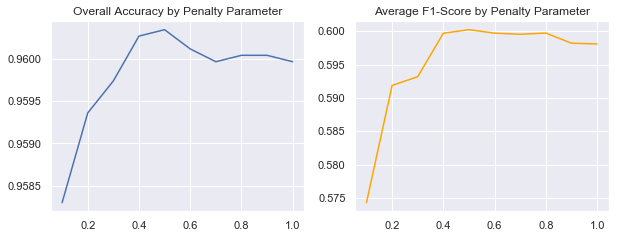

In [146]:
plt.figure(figsize=(10, 3.5))

plt.subplot(1,2,1)
plt.plot(penalty_params,scores[1:,0])
plt.title("Overall Accuracy by Penalty Parameter")

plt.subplot(1,2,2)
plt.plot(penalty_params,scores[1:,1], c='orange')
plt.title("Average F1-Score by Penalty Parameter")

There appears to be a clear peak performance at C=0.5, so we will refit our SVM with this specification.

In [147]:
svm = LinearSVC(C=.5) # use 0.3 since Macro F1-Score is our priority
svm.fit(all_X_train,y_train)
preds = svm.predict(all_X_validation)
all_features_acc = accuracy_score(y_validation, preds)
all_features_f1 = f1_score(y_validation, preds, average='macro')
print("Overall Accuracy: ", all_features_acc)
print("Macro F1-Score: ", all_features_f1)

Overall Accuracy:  0.9603414413053332
Macro F1-Score:  0.6002306437623588


C:\Users\RHedg\.conda\envs\opencv\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [148]:
print(classification_report(y_validation,preds))

              precision    recall  f1-score   support

           O       0.99      1.00      0.99     11290
         art       0.00      0.00      0.00        13
         eve       0.75      0.39      0.51        23
         geo       0.75      0.84      0.79       500
         gpe       0.86      0.68      0.76       267
         nat       0.00      0.00      0.00         8
         org       0.77      0.63      0.69       395
         per       0.80      0.90      0.85       460
         tim       0.90      0.73      0.81       282

   micro avg       0.96      0.96      0.96     13238
   macro avg       0.65      0.57      0.60     13238
weighted avg       0.96      0.96      0.96     13238



C:\Users\RHedg\.conda\envs\opencv\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\RHedg\.conda\envs\opencv\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\RHedg\.conda\envs\opencv\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Text(89.18, 0.5, 'Predicted Entity')

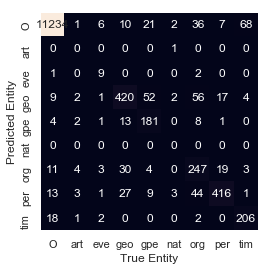

In [149]:
conf_mat = confusion_matrix(y_validation,preds)
sns.heatmap(conf_mat.T, square=True, annot=True, fmt='d', cbar=False,
           xticklabels=np.unique(y_validation),
           yticklabels=np.unique(y_validation))
plt.xlabel('True Entity')
plt.ylabel('Predicted Entity')

Let's now test our final model on our final testing set:

**Results:**
- Overall Accuracy = 0.959
- Macro F1-score: 0.615

Note that due to small sample size of our final test set, the Artifact Entity resulted in no predictions, defaulting the F1-Score to 0.0 for Artifact, and thus driving down our Macro F1-Score. Overall, our scores are slightly below that of our validation sets. This may be due to the randomization of the sample size, but it may also indicate minor information leakage. Regardless, this small gap is not large enough to be of concern to me.


In [33]:
preds = svm.predict(all_X_test)
final_test_acc = accuracy_score(y_test, preds)
final_test_f1 = f1_score(y_test, preds, average='macro')
print("Overall Accuracy: ", final_test_acc)
print("Macro F1-Score: ", final_test_f1)

Overall Accuracy:  0.9594921402660218
Macro F1-Score:  0.6145609141938446


C:\Users\RHedg\.conda\envs\opencv\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [34]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           O       0.99      1.00      0.99      5619
         art       0.00      0.00      0.00         9
         eve       0.33      0.20      0.25         5
         geo       0.69      0.85      0.76       253
         gpe       0.92      0.68      0.78       147
         nat       0.50      0.25      0.33         4
         org       0.79      0.63      0.70       222
         per       0.79      0.88      0.83       208
         tim       0.99      0.79      0.88       149

   micro avg       0.96      0.96      0.96      6616
   macro avg       0.67      0.59      0.61      6616
weighted avg       0.96      0.96      0.96      6616



C:\Users\RHedg\.conda\envs\opencv\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\RHedg\.conda\envs\opencv\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\RHedg\.conda\envs\opencv\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Final Notes on Modeling:

While SVM was well-suited for this classification task due to the high-dimensional data, various other modeling approaches were explored during this process, most of which did not perform nearly to the level of the SVM. Notably, tree-based methods such as Random Forests and Tree Boosting using xgboost performed at a significantly inferior level. Multinomial Logistic Regression outperformed tree-based methods, but was still weaker than SVM.

Finally, a simple Neural Net approach using dense layers was explored. It was found that this model very quickly overfits the data when using multiple hidden layers. Additionally, a neural net with only one hidden layer would be somewhat redundant of our SVM approach, which is essentially a 1-layer neural net. Even with a non-linear activation function, this would be roughly equivalent to an SVM using the kernel trick, which was attempted and produced insignificant results.

# Conclusions and Next Steps
The final SVM model performed comparatively well in classifying Named Entities from words in our dataset with an overall accuracy of 96%.

#### There are a few additional steps that could be taken to improve our model moving forward:
- Extract additional features from our data (use combinations of 2+ words, sentence length, word index within sentence etc.).
- Condense the feature set of vectorized words/prior words/next words into a more concise, and potentially more meaningful feature set. A few ideas to consider are to use word embeddings, PCA, or we can use Random Forests to identify and remove words of trivial value to the model.
- Acquire a larger data set.
- Explore additional architectures and functional forms of neural nets. Notably, an LSTM approach could more effectively extract context from prior words in a sentence.

# PS: An Attempt Using XGBoost

In the following section, we attempt to apply the XGBoost algorithm on our data. Since GBM will be painfully slow (if it will run at all) on a feature matrix of ~1500 columns, we still begin by reducing our dimension to 150 using Principle Component Analysis.

In [151]:
import xgboost as xgb

In [173]:
pca = PCA(n_components=150, whiten=True)
pca.fit(all_X_train)
pca_all_X_train = pca.transform(all_X_train)
pca_all_X_validation = pca.transform(all_X_validation)

Now we will conduct a round of parameter tuning on our XGBoost model. Note that we only will fit 10 trees at this point, in order to reduce the time complexity of this process.

In [175]:
max_depth = list([15, 20])
min_child_weight = list([1, 4])
gamma = list([.1, .4])

# define grid
param_grid = dict(max_depth=max_depth)

reg = xgb.XGBClassifier(n_estimators=10, gamma=.4, min_child_weight=4)
grid = GridSearchCV(reg, param_grid, cv=2, scoring='accuracy', return_train_score=False, n_jobs=-1)
grid.fit(pca_all_X_train, y_train)

def report_results(grid):
    cv_keys = ('mean_test_score', 'std_test_score', 'params')
    print('mean_test_score +/ std_test_score, {params}') 
    for r, _ in enumerate(grid.cv_results_['mean_test_score']):
        bf = '*' if grid.cv_results_[cv_keys[0]][r]==grid.best_score_ else ' ' #star the best score
        print(bf+"%0.3f +/- %0.2f %r"
          % (grid.cv_results_[cv_keys[0]][r],
             grid.cv_results_[cv_keys[1]][r] / 2.0,
             grid.cv_results_[cv_keys[2]][r]))

report_results(grid)
print(grid.best_estimator_)

mean_test_score +/ std_test_score, {params}
*0.929 +/- 0.00 {'max_depth': 15}
 0.929 +/- 0.00 {'max_depth': 20}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.4, learning_rate=0.1, max_delta_step=0,
       max_depth=15, min_child_weight=4, missing=None, n_estimators=10,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


We have arrived on our optimal parameters of a max depth of 15 levels, a min_child_weight of 4, and a gamma value of .4. Let's now refit our model by now ensembling on 150 GB Trees.

In [176]:
xgb_model = xgb.XGBClassifier(max_depth = 15, n_estimators=150, min_child_weight=4)
xgb_model.fit(pca_all_X_train, y_train)
preds = xgb_model.predict(pca_all_X_validation)
xgb_test_acc = accuracy_score(y_validation, preds)
xgb_test_f1 = f1_score(y_validation, preds, average='macro')
print("Overall Accuracy: ", xgb_test_acc)
print("Macro F1-Score: ", xgb_test_f1)

Overall Accuracy:  0.9453844991690588
Macro F1-Score:  0.4938477708926939
